In [191]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from numpy import *
import pandas as pd
from sklearn import datasets
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, StandardScaler
from sklearn import model_selection
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from xgboost import cv
import sklearn.metrics
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [192]:
#kc = pd.read_csv('/Users/planteatre/Downloads/kc.csv')
kc = pd.read_csv("M:\Amogh\Documents\kingcounty\kc.csv")
kc = kc.drop(['Unnamed: 0'], axis=1)
to_drop = ['sqft_lot15', 'sqft_living15', 'sqft_above', 'sqft_basement', 'grades_five_miles', 'id',
'outside', 'kss', 'kss_distance', 'yrs_since_built', 'Lib_Ten_Miles', 'year', 'space needle distance', 
'Crime/Population', 'Burglary/Population', 'Property_Crime/Population', 'Violent_Crime', 'num_schools_one_mile', 
'num_schools_two_miles', 'Population']
kc = kc.drop(to_drop, axis=1)

In [193]:
kc.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,parks_five_miles,City,Crime_Total,Larceny,Vehicle_Theft,Nearest_Distance_Library,Lib_Five_Miles,house_five_miles,zip_price,price_one_half_mile
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,34,Seattle,89379.0,0.042260,0.008312,1.671735,12,2717,310952.651341,326826.569444
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,...,40,Seattle,89379.0,0.042260,0.008312,2.407216,4,4279,469288.180929,412829.147887
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,...,26,Kenmore,642.0,0.008087,0.001508,1.734411,6,2678,463481.737589,439566.914110
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,...,17,Seattle,89379.0,0.042260,0.008312,2.085631,4,2078,551489.011450,459443.787402
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,16,Sammamish,794.0,0.004548,0.000451,1.180093,3,1893,686004.879545,581703.042254


In [194]:
kc['date'] = pd.to_datetime(kc['date'])
kc['month'] = pd.DatetimeIndex(kc['date']).month

## Binning

<AxesSubplot:xlabel='grade-bins', ylabel='price'>

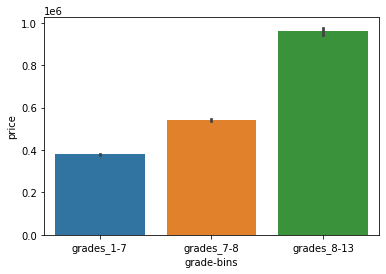

In [195]:
# grade bins
grade_bins = [1, 7, 8, 13]
grade_labels = ['grades_1-7', 'grades_7-8', 'grades_8-13']
kc['grade-bins'] = pd.cut(kc['grade'], bins=grade_bins, labels=grade_labels)
sns.barplot(x=kc['grade-bins'], y=kc['price'])

<AxesSubplot:xlabel='cond-bins', ylabel='price'>

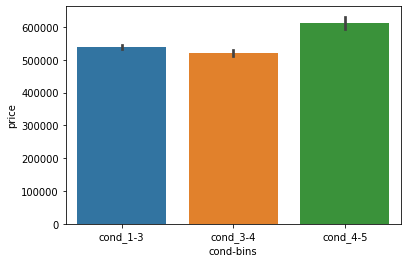

In [196]:
# condition bins
cond_bins = [1, 3, 4, 5]
cond_labels = ['cond_1-3', 'cond_3-4', 'cond_4-5']
kc['cond-bins'] = pd.cut(kc['condition'], bins=cond_bins, labels=cond_labels)
sns.barplot(x=kc['cond-bins'], y=kc['price'])

<AxesSubplot:xlabel='lib_five_bins', ylabel='price'>

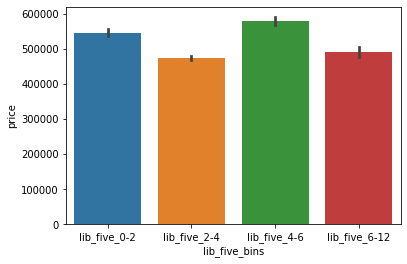

In [197]:
# lib five miles bins
lib_5_bins = [0, 2, 4, 6, 12]
lib_5_labels = ['lib_five_0-2', 'lib_five_2-4', 'lib_five_4-6', 'lib_five_6-12']
kc['lib_five_bins'] = pd.cut(kc['Lib_Five_Miles'], bins=lib_5_bins, labels=lib_5_labels)
sns.barplot(x=kc['lib_five_bins'], y=kc['price'])

In [198]:
kc.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'yrs since renovated',
       'airport', 'uw_distance', 'pike_distance', 'kc_international_airport',
       'nearest_distance_school', 'num_schools_five_miles',
       'nearest_park_distance', 'parks_one_mile', 'parks_five_miles', 'City',
       'Crime_Total', 'Larceny', 'Vehicle_Theft', 'Nearest_Distance_Library',
       'Lib_Five_Miles', 'house_five_miles', 'zip_price',
       'price_one_half_mile', 'month', 'grade-bins', 'cond-bins',
       'lib_five_bins'],
      dtype='object')

# xgboost evaluations

In [214]:
le = LabelEncoder()
ohe = OneHotEncoder()

categorical_cols = ['City', 'grade-bins', 'cond-bins', 'lib_five_bins']
kc[categorical_cols] = kc[categorical_cols].apply(le.fit_transform)

ohe.fit(kc[categorical_cols])
ohe_labels = ohe.transform(kc[categorical_cols]).toarray()

explan = kc.drop(['price', 'date', 'Lib_Five_Miles'], axis = 1) # drop categorical and reponse

response = pd.DataFrame(kc.price)

X = explan
Y = response

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=0)
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
learn_rate = 0.04
n_est = 900
tree_md = 8

xgb_opt = XGBRegressor(learning_rate=learn_rate,
                       n_estimators=n_est,
                       max_depth=tree_md,
                       nthread=4,
                       subsample=0.9,
                       colsample_bytree=0.7, 
                       min_child_weight=4,
                       objective='reg:squarederror', seed=1)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]
xg_mod = xgb_opt.fit(X_train_scaled, y_train, eval_set=eval_set, early_stopping_rounds=15)
print(f'Score on Valuation set: {xg_mod.score(X_test_scaled, y_test)}')

[0]	validation_0-rmse:633879.18750	validation_1-rmse:608132.87500
[1]	validation_0-rmse:610441.93750	validation_1-rmse:585282.68750
[2]	validation_0-rmse:587841.75000	validation_1-rmse:563580.37500
[3]	validation_0-rmse:566175.56250	validation_1-rmse:542977.50000
[4]	validation_0-rmse:545221.50000	validation_1-rmse:522839.21875
[5]	validation_0-rmse:525338.31250	validation_1-rmse:503577.21875
[6]	validation_0-rmse:506157.34375	validation_1-rmse:485142.00000
[7]	validation_0-rmse:487742.31250	validation_1-rmse:467260.40625
[8]	validation_0-rmse:470076.90625	validation_1-rmse:450295.93750
[9]	validation_0-rmse:453441.56250	validation_1-rmse:434211.06250
[10]	validation_0-rmse:437012.59375	validation_1-rmse:418600.40625
[11]	validation_0-rmse:421171.50000	validation_1-rmse:403595.00000
[12]	validation_0-rmse:406056.18750	validation_1-rmse:389255.59375
[13]	validation_0-rmse:391642.78125	validation_1-rmse:375690.06250
[14]	validation_0-rmse:377945.68750	validation_1-rmse:362268.09375
[15]	

In [ ]:
'''pipe = Pipeline(steps=[
    ("MinMax Scaling", MinMaxScaler()),
    ("xgb regression", XGBRegressor(learning_rate=learn_rate,
                       n_estimators=n_est,
                       max_depth=tree_md,
                       nthread=4,
                       subsample=0.9,
                       colsample_bytree=0.7, 
                       min_child_weight=4,
                       objective='reg:squarederror', seed=1))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
r2_score(y_true=y_test, y_pred=y_pred)'''